In [1]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

# Training Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=16                                        
device=set_device("cuda", 1)
train_size=0.00108

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi2D     = AWLoss2D(reduction="sum", std=1e-4, store_filters=True, alpha=0.02)
switch_at_epoch = 0 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse  

Cuda installed! Running on GPU 1 GeForce RTX 2080 Ti!


In [6]:
# Training loop
def train_model(model, optimizer, train_loader, nepochs=150, switch_at_epoch=0, vis_frequency=10):
    print("\n\nTraining started ...")
    all_loss, all_mse, all_kl = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            if epoch < switch_at_epoch:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, l2loss, device=device)
            else:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, awi2D, device=device)
            epoch_mse = validate(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
            all_loss.append(epoch_loss.item())
            all_mse.append(epoch_mse.item())
            all_kl.append(epoch_kl.item())
            bar.update(epoch)
                

            # Metric logs and plots
            log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_awi1d_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
            if epoch % vis_frequency == 0 or epoch==nepochs-1:
                idx = random.randint(0, len(trainds))
                idx=-1
                X = trainds[idx][0].unsqueeze(0).to(device)
                recon = model(X)
                if isinstance(recon, tuple): recon = recon[0] # in case model returns more than one output, recon must be the first
                
                f = awi2D(recon, X)
                v, T = awi2D.v_all[0], awi2D.T_arr

                print("\n", log)
                print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())

                plot_grad_flow(model.named_parameters())

                fig, axs = plt.subplots(2,3)
                axs[0, 0].imshow(recon[0].permute(1,2,0).cpu().detach().numpy(), vmin=0., vmax=1.)
                axs[0, 0].set_title("recon")

                axs[0, 1].imshow(X[0].permute(1,2,0).cpu().detach().numpy(), vmin=0., vmax=1.)
                axs[0, 1].set_title("orig")

                axs[0, 2].imshow(X[0].permute(1,2,0).cpu().detach().numpy() - recon[0].permute(1,2,0).cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
                axs[0, 2].set_title("diff")

                axs[1, 0].imshow(T.detach().cpu().numpy())
                axs[1, 0].set_title("T-2D")

                axs[1, 1].imshow(v.detach().cpu().numpy())
                axs[1, 1].set_title("v-2D")

                axs[1, 2].plot((T.flatten() - v.flatten()).detach().cpu().numpy())
                axs[1, 2].set_ylim(None, 1.1)
                axs[1, 2].set_title("T2D - v2D")

                plt.show()

                fig, axs = plt.subplots(1,3, figsize=(7, 3))
                axs[0].plot(all_loss, label="aw_loss2d")
                axs[0].legend()
                axs[0].set_xlabel("epoch")
                axs[1].plot(all_mse, label="mse")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[2].plot(all_kl, label="kl_loss")
                axs[2].legend()
                axs[2].set_xlabel("epoch")
                plt.show()

# CIFAR10 Example

## Datasets and Dataloaders

In [7]:
# Train Transforms
train_transform = Compose([
    Resize(28),
])

# Datasets and dataloaders
ds = CIFAR10("./", download=True, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = torch.from_numpy(ds.data[train_idx]) / 255., torch.tensor(ds.targets)[train_idx]
X_train = X_train.permute(0, 3, 1, 2)
trainds = TransformTensorDataset(X_train.float(), y_train.float(), transform=train_transform)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())

Files already downloaded and verified
Trainable Images: 54
torch.Size([1, 3, 28, 28]) 0.014325735159218311 1.0


## Autoencoder (FC)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.06658230721950531, 'train_awi1d_loss': 20.72332000732422, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


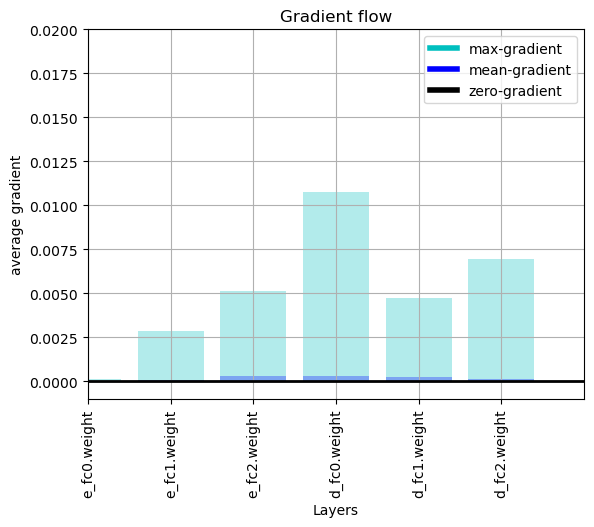

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


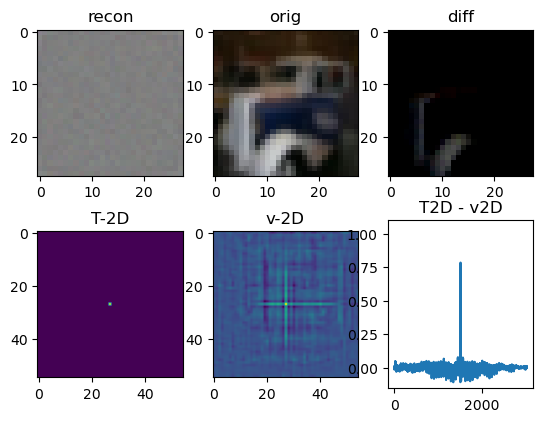

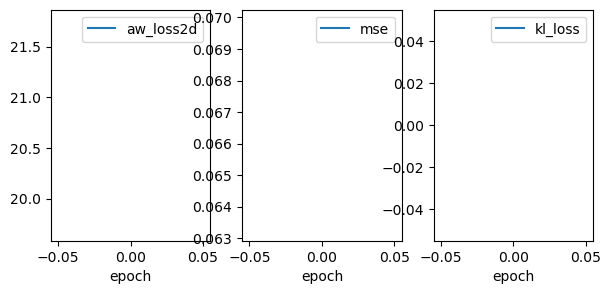

 20% (20 of 100) |####                   | Elapsed Time: 0:05:12 ETA:   0:20:50


 {'epoch': 20, 'train_mse': 0.0738266259431839, 'train_awi1d_loss': 18.20630645751953, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


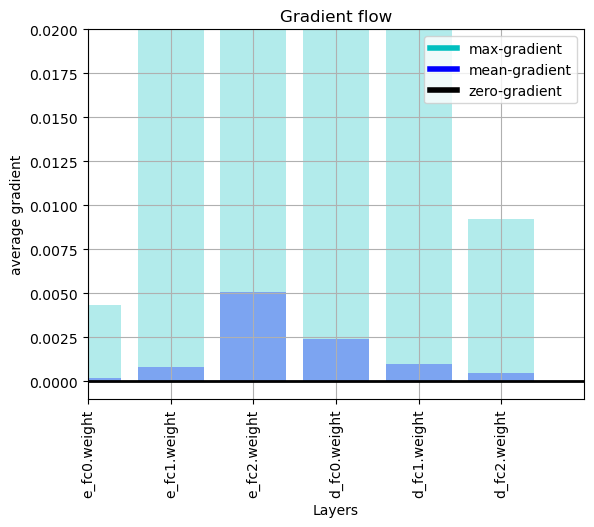

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


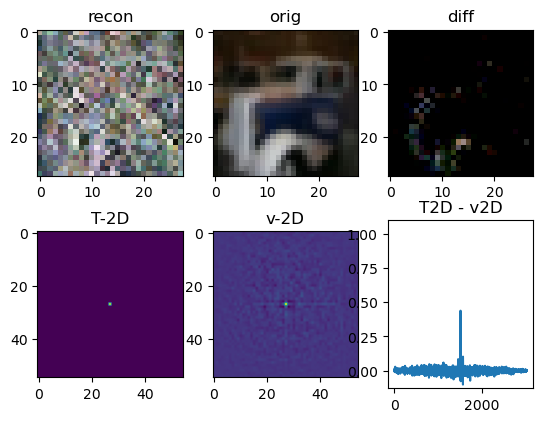

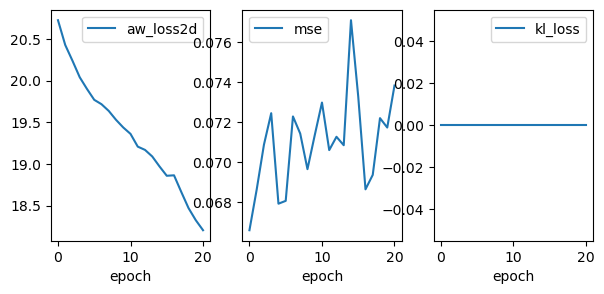

 40% (40 of 100) |#########              | Elapsed Time: 0:10:26 ETA:   0:15:35


 {'epoch': 40, 'train_mse': 0.05895436927676201, 'train_awi1d_loss': 15.279250144958496, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


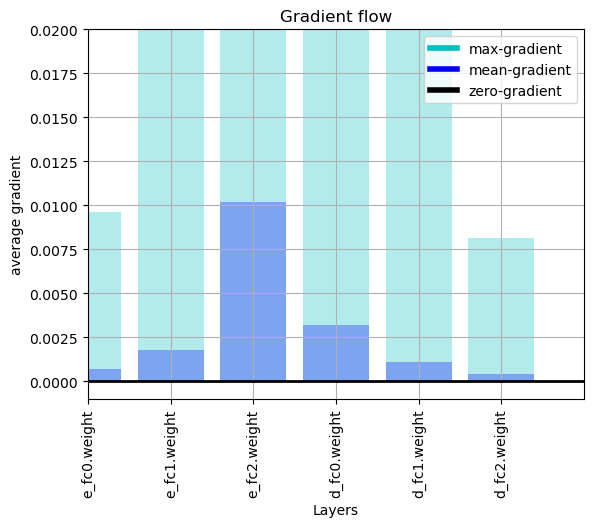

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


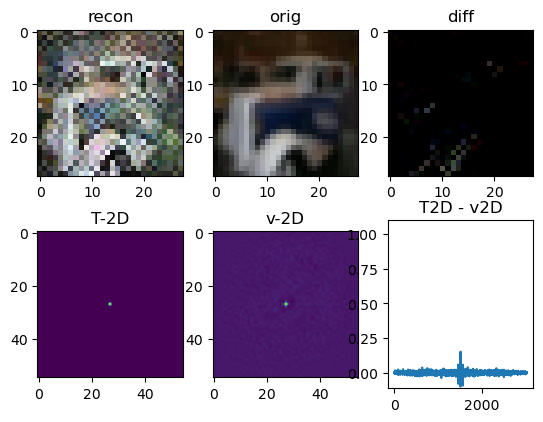

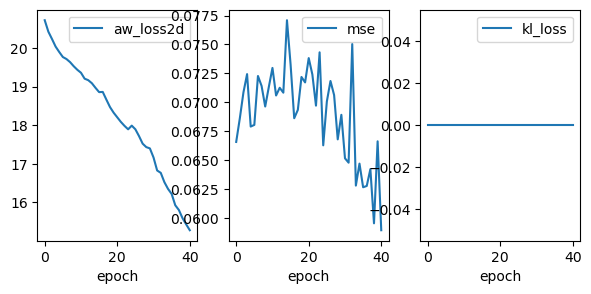

 60% (60 of 100) |#############          | Elapsed Time: 0:15:39 ETA:   0:10:24


 {'epoch': 60, 'train_mse': 0.05745804309844971, 'train_awi1d_loss': 13.243440628051758, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


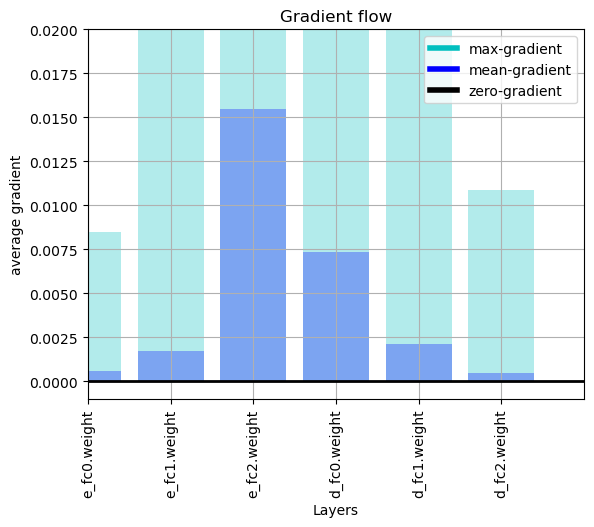

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


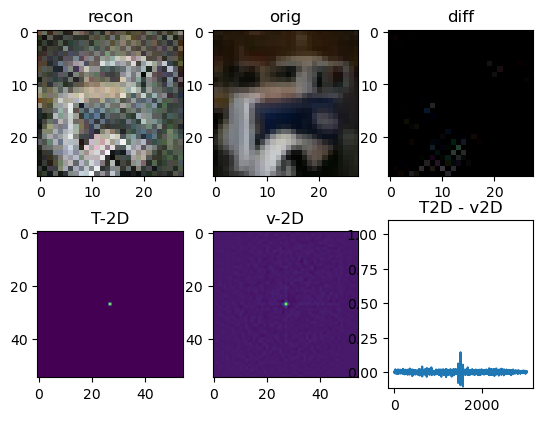

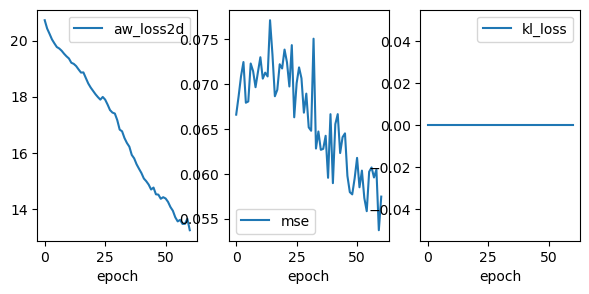

 80% (80 of 100) |##################     | Elapsed Time: 0:20:51 ETA:   0:05:11


 {'epoch': 80, 'train_mse': 0.06115787848830223, 'train_awi1d_loss': 11.74079418182373, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


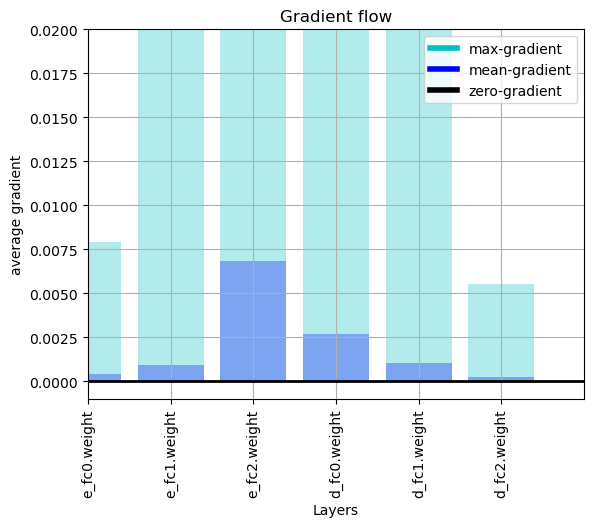

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


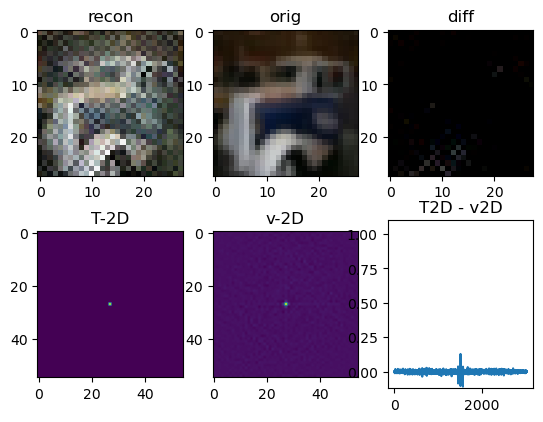

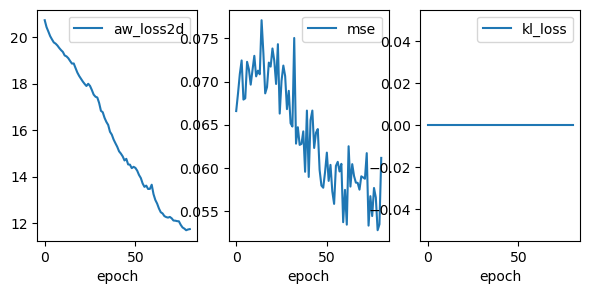

 99% (99 of 100) |###################### | Elapsed Time: 0:25:50 ETA:   0:00:15


 {'epoch': 99, 'train_mse': 0.0574059933423996, 'train_awi1d_loss': 11.265996932983398, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


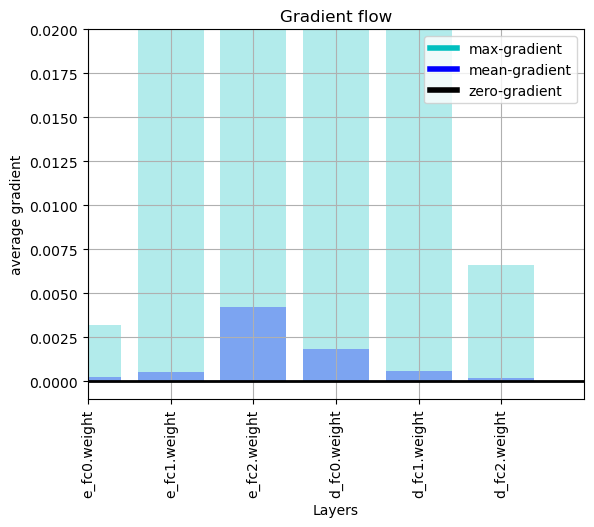

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


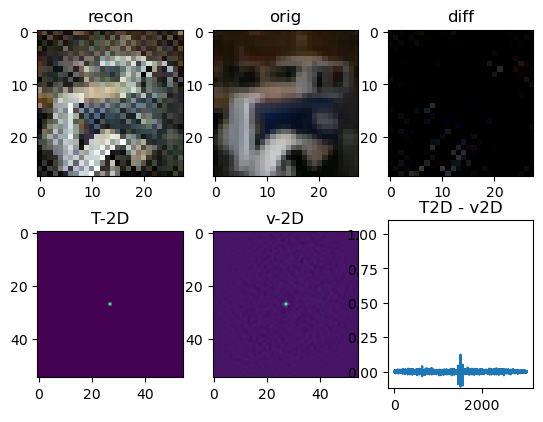

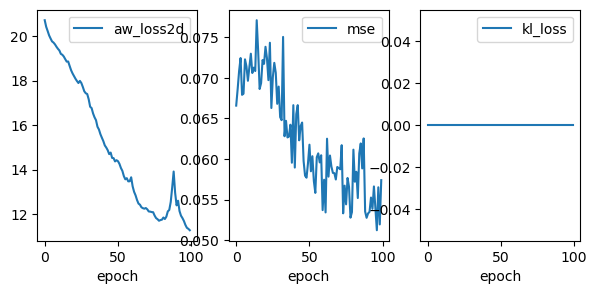

100% (100 of 100) |######################| Elapsed Time: 0:25:51 Time:  0:25:51


In [8]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Visualise Loss Landscape of Autoencoder

Train Subset len:  1
Angle between x_dir and y_dir: 90.05 °


100% (625 of 625) |######################| Elapsed Time: 0:04:52 Time:  0:04:52


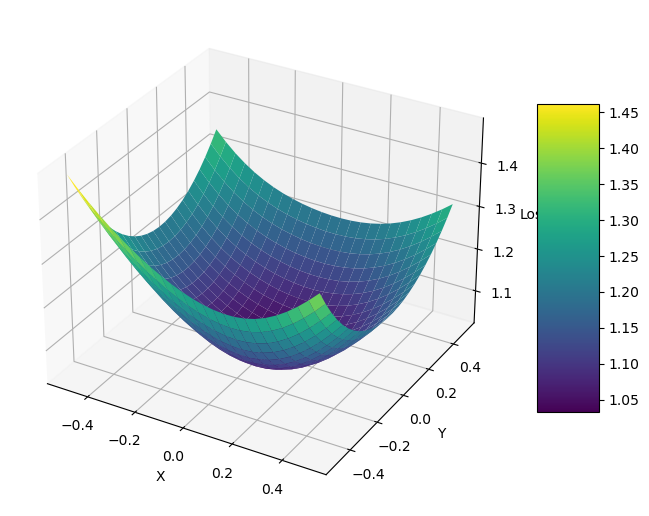

In [9]:
train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=1)))
train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Train Subset len: ", len(train_subset))
xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi2D, device=device)


## Variational Autoencoder (FC)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.06793513894081116, 'train_awi1d_loss': 20.94304656982422, 'train_kl_loss': 286.55810546875}
 argidx T, v:  1512 1512


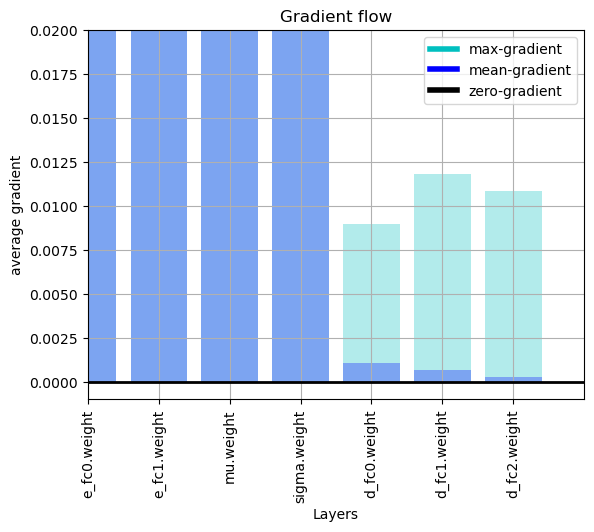

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


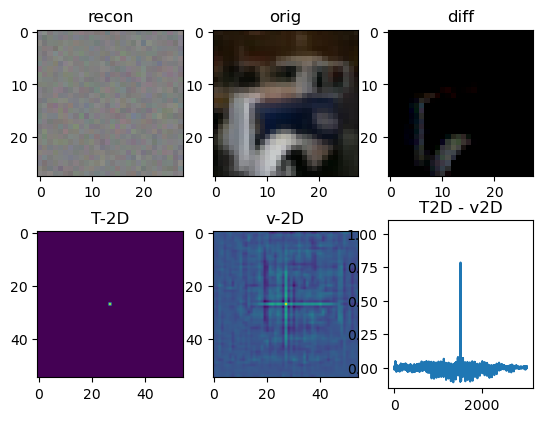

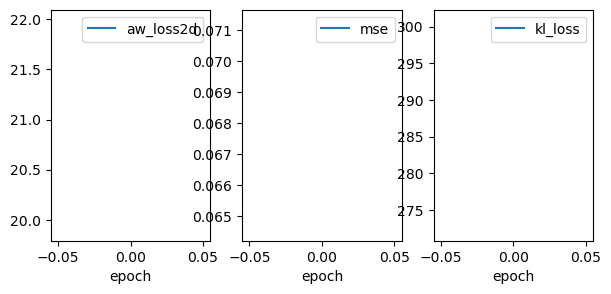

 20% (20 of 100) |####                   | Elapsed Time: 0:05:29 ETA:   0:20:53


 {'epoch': 20, 'train_mse': 0.06924005597829819, 'train_awi1d_loss': 19.77944564819336, 'train_kl_loss': 216.04673767089844}
 argidx T, v:  1512 1512


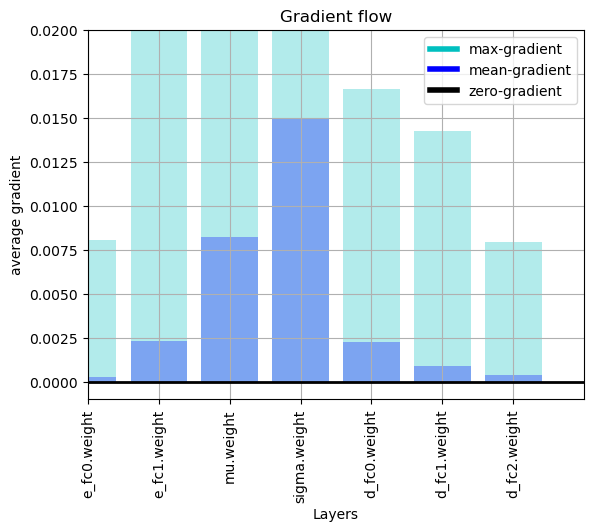

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


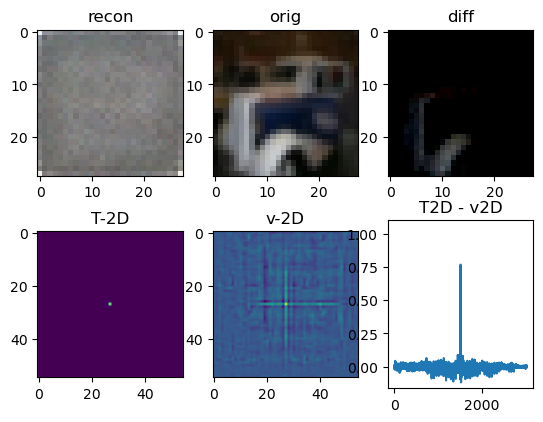

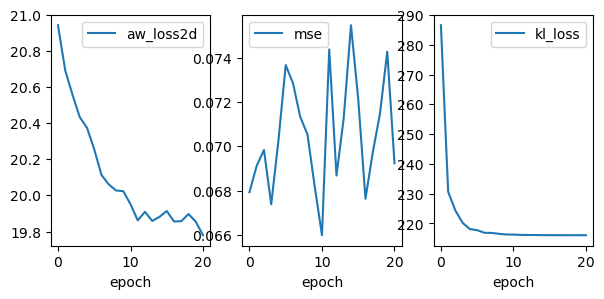

 40% (40 of 100) |#########              | Elapsed Time: 0:11:05 ETA:   0:17:28


 {'epoch': 40, 'train_mse': 0.06957788020372391, 'train_awi1d_loss': 19.75606918334961, 'train_kl_loss': 216.10250854492188}
 argidx T, v:  1512 1512


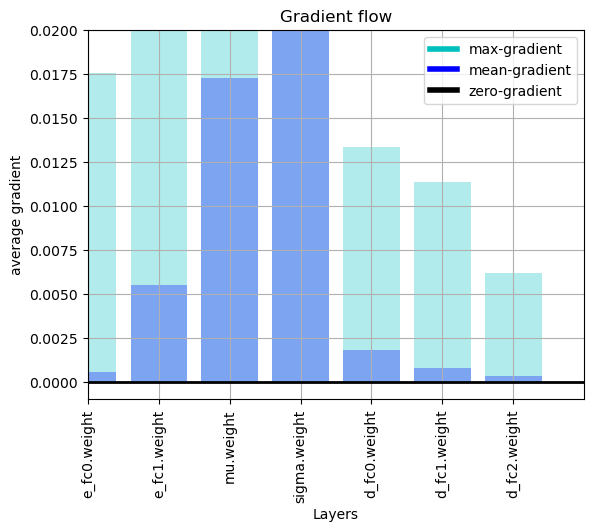

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


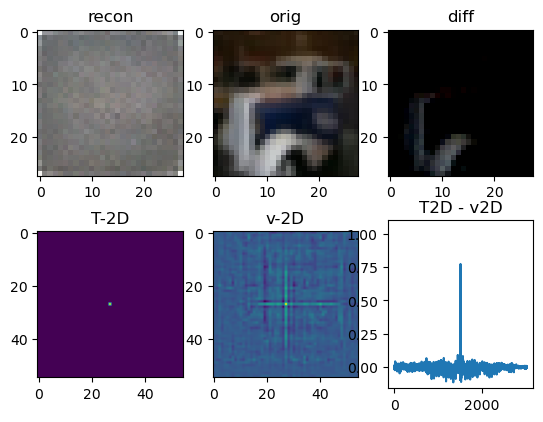

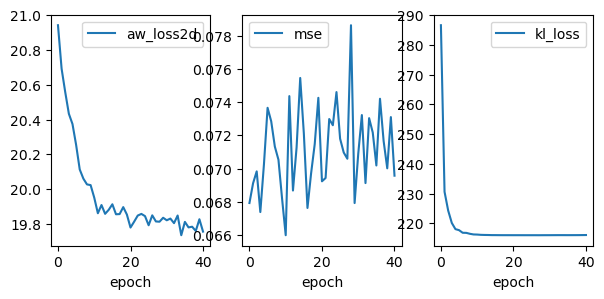

 60% (60 of 100) |#############          | Elapsed Time: 0:16:20 ETA:   0:10:22


 {'epoch': 60, 'train_mse': 0.07567473500967026, 'train_awi1d_loss': 19.763334274291992, 'train_kl_loss': 216.03565979003906}
 argidx T, v:  1512 1512


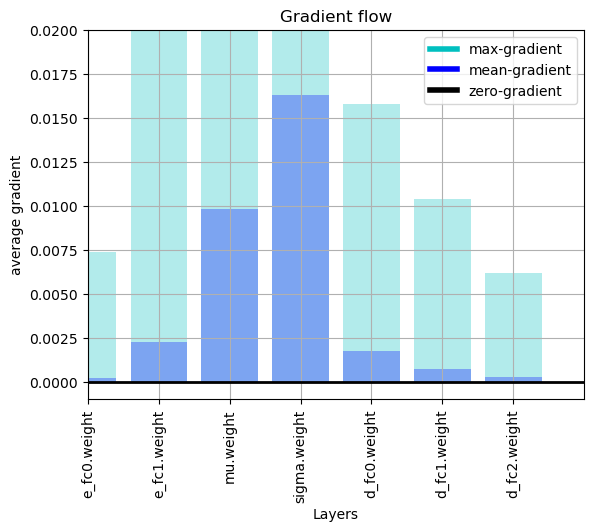

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


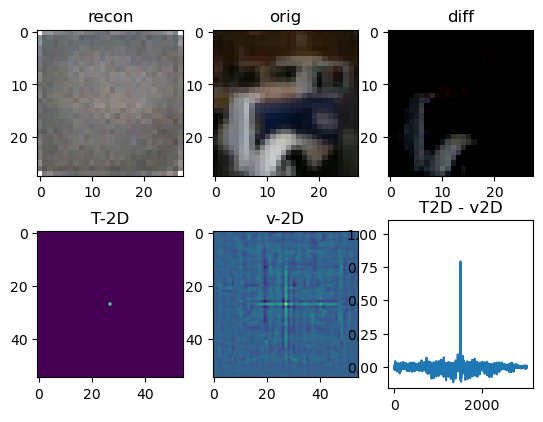

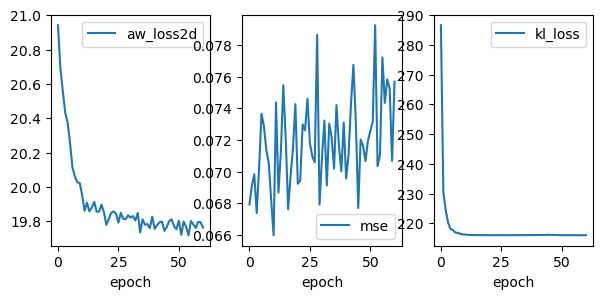

 80% (80 of 100) |##################     | Elapsed Time: 0:21:31 ETA:   0:05:12


 {'epoch': 80, 'train_mse': 0.07943153381347656, 'train_awi1d_loss': 19.758865356445312, 'train_kl_loss': 216.0413360595703}
 argidx T, v:  1512 1512


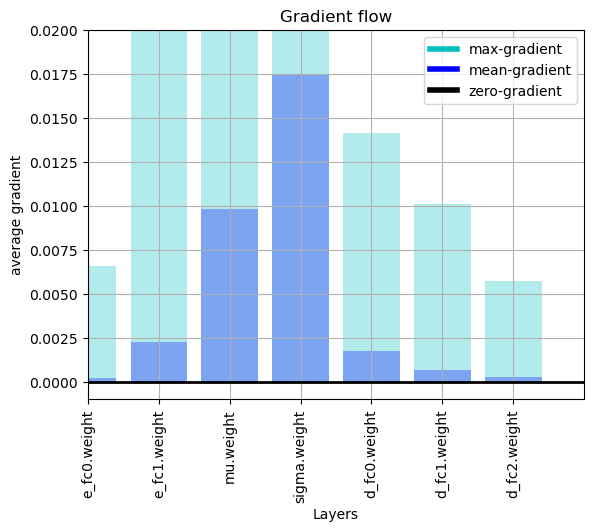

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


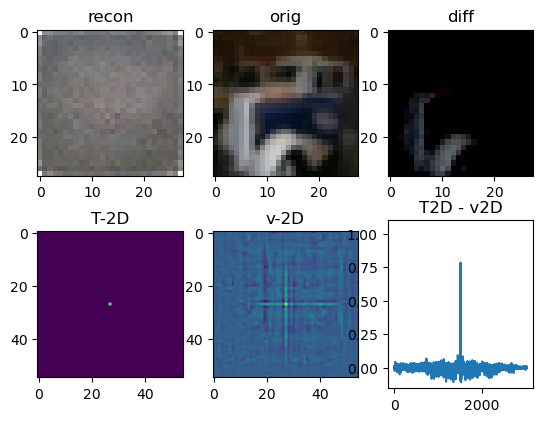

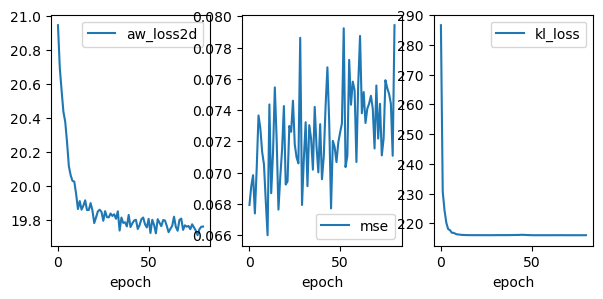

 99% (99 of 100) |###################### | Elapsed Time: 0:26:27 ETA:   0:00:15


 {'epoch': 99, 'train_mse': 0.07769592851400375, 'train_awi1d_loss': 19.680139541625977, 'train_kl_loss': 216.03082275390625}
 argidx T, v:  1512 1512


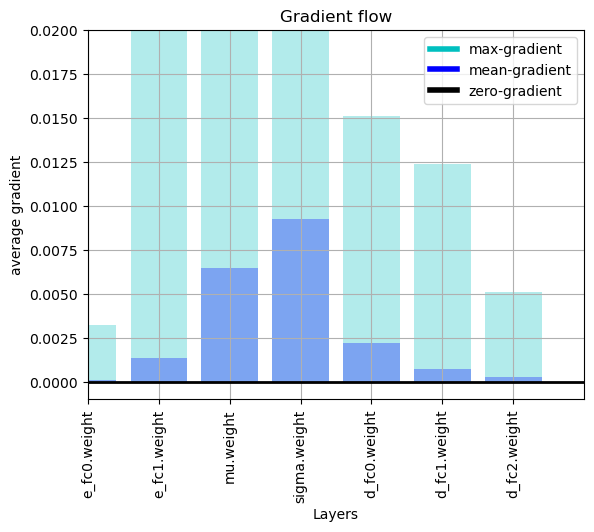

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


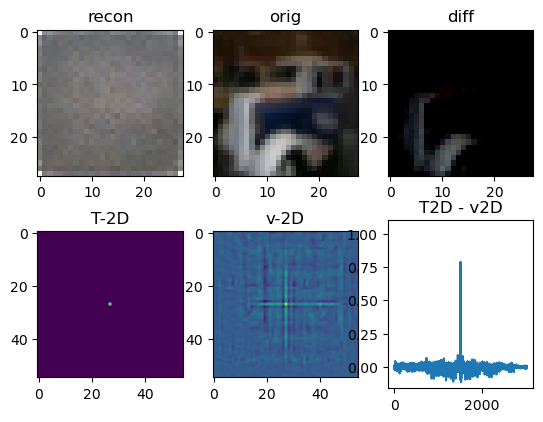

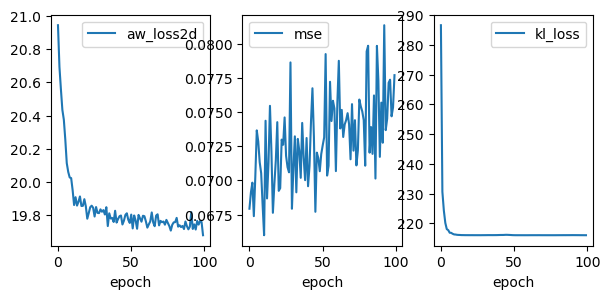

100% (100 of 100) |######################| Elapsed Time: 0:26:28 Time:  0:26:28


In [10]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)
 
# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Autoencoder (CNN)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.06791150569915771, 'train_awi1d_loss': 20.724384307861328, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


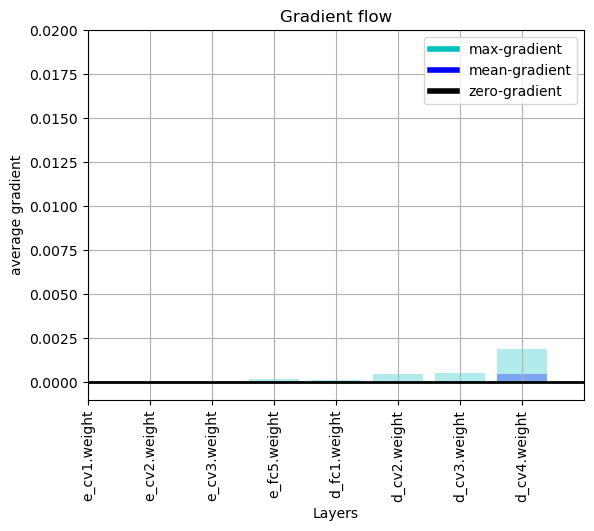

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


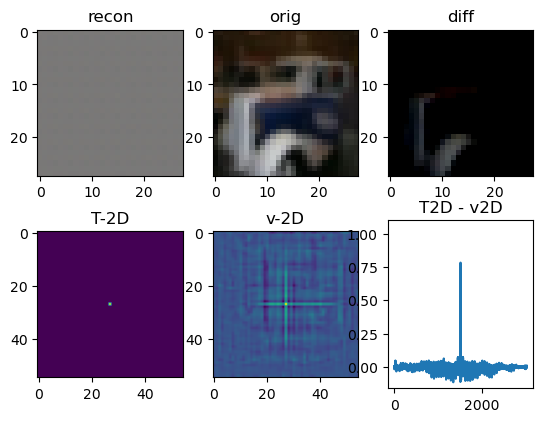

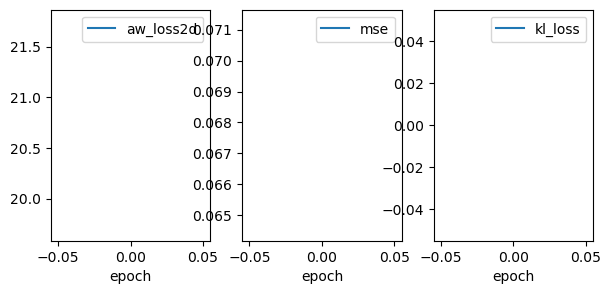

 20% (20 of 100) |####                   | Elapsed Time: 0:05:11 ETA:   0:20:44


 {'epoch': 20, 'train_mse': 0.07423398643732071, 'train_awi1d_loss': 19.653867721557617, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


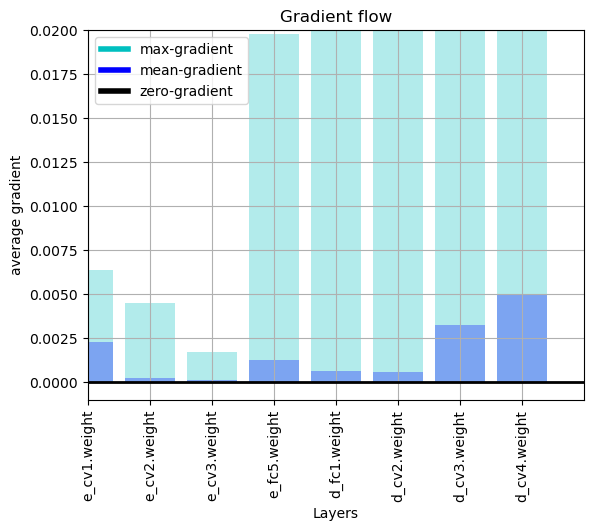

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


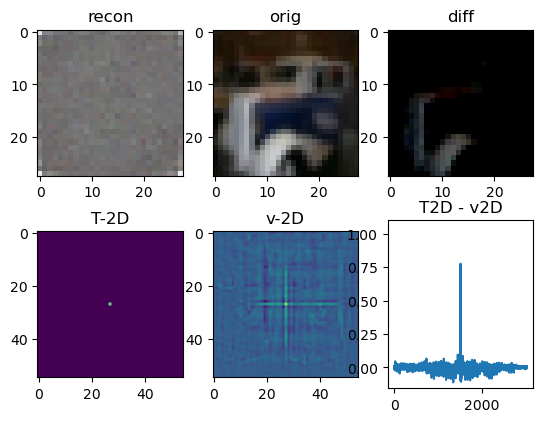

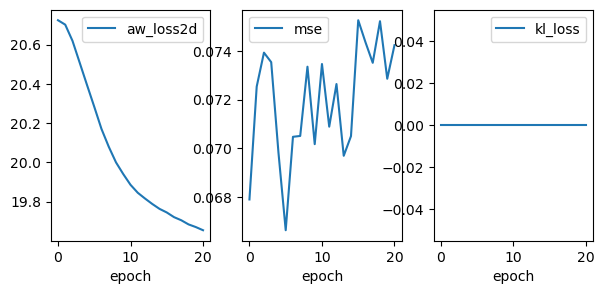

 40% (40 of 100) |#########              | Elapsed Time: 0:10:22 ETA:   0:15:27


 {'epoch': 40, 'train_mse': 0.07476194947957993, 'train_awi1d_loss': 19.169631958007812, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


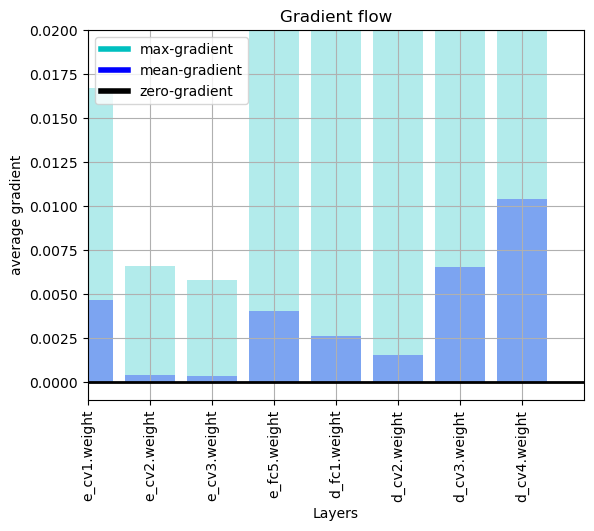

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


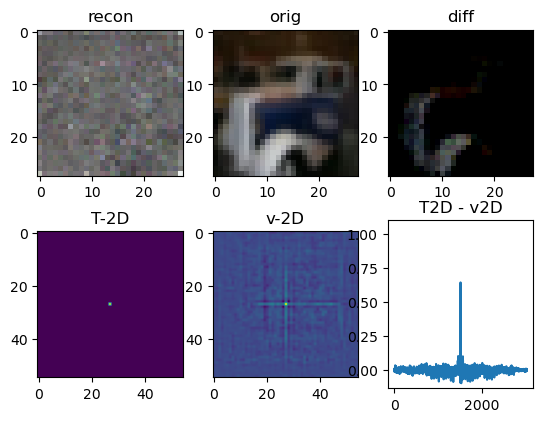

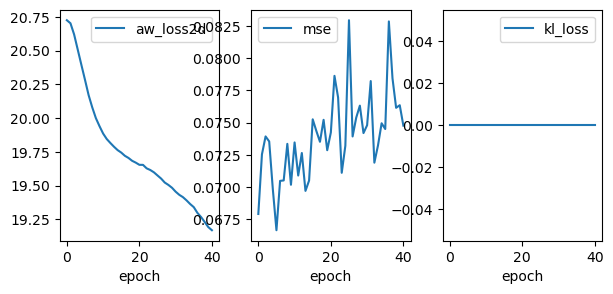

 60% (60 of 100) |#############          | Elapsed Time: 0:15:34 ETA:   0:10:19


 {'epoch': 60, 'train_mse': 0.08459213376045227, 'train_awi1d_loss': 17.938087463378906, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


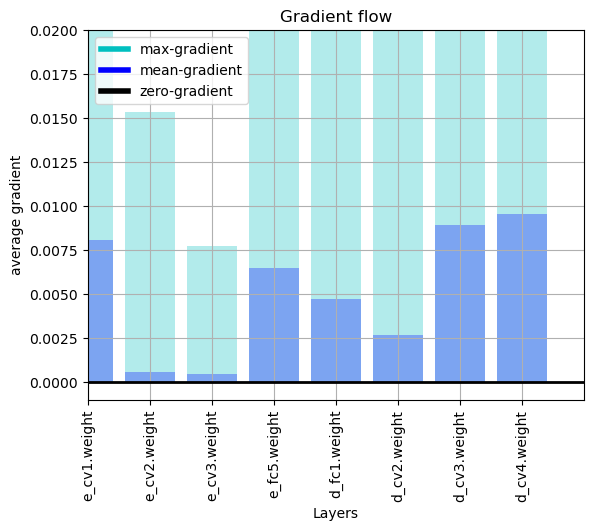

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


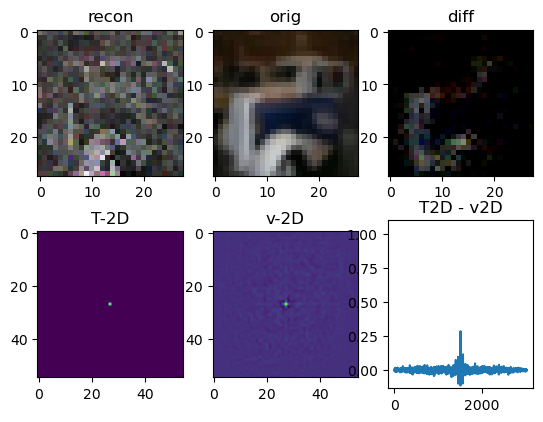

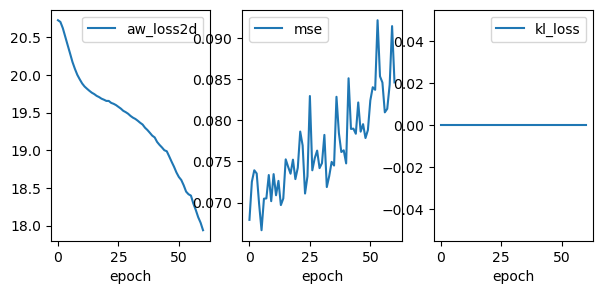

 80% (80 of 100) |##################     | Elapsed Time: 0:20:48 ETA:   0:05:10


 {'epoch': 80, 'train_mse': 0.0915619283914566, 'train_awi1d_loss': 16.423870086669922, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


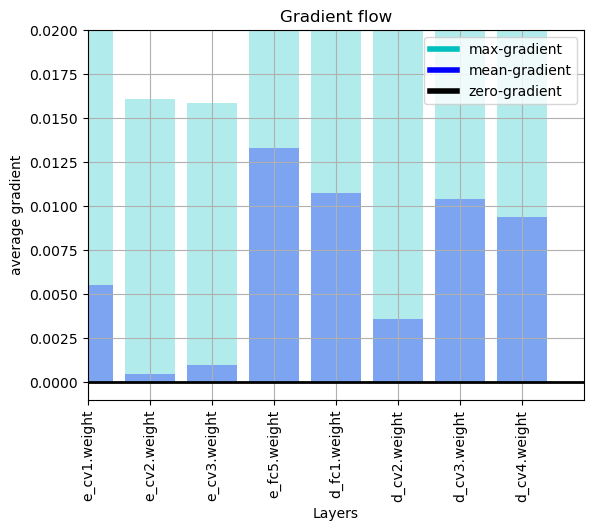

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


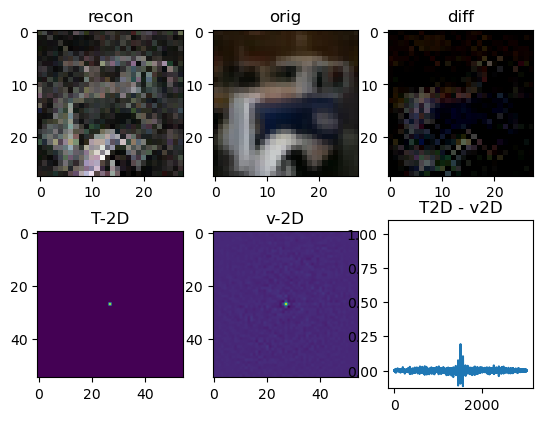

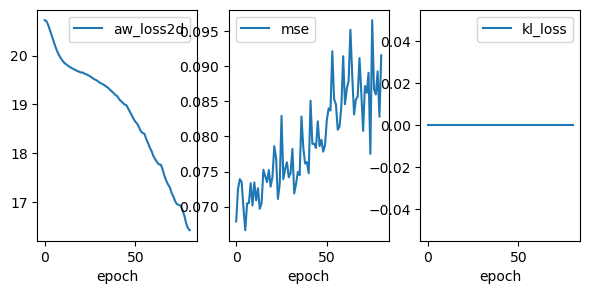

 99% (99 of 100) |###################### | Elapsed Time: 0:25:44 ETA:   0:00:15


 {'epoch': 99, 'train_mse': 0.08872129023075104, 'train_awi1d_loss': 15.244827270507812, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


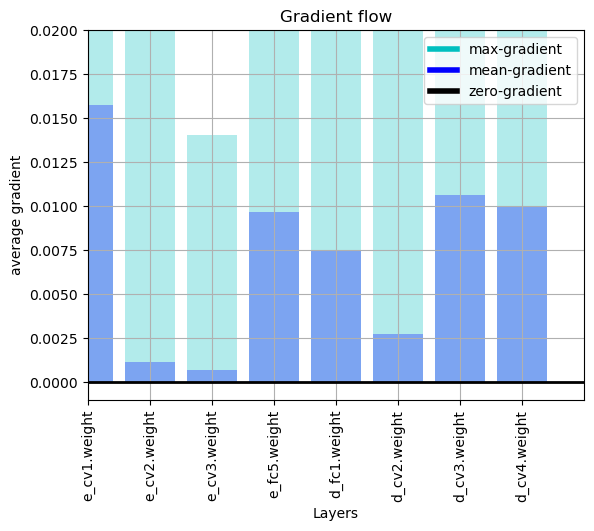

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


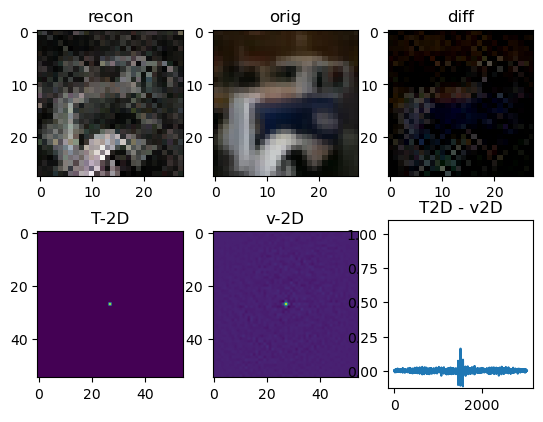

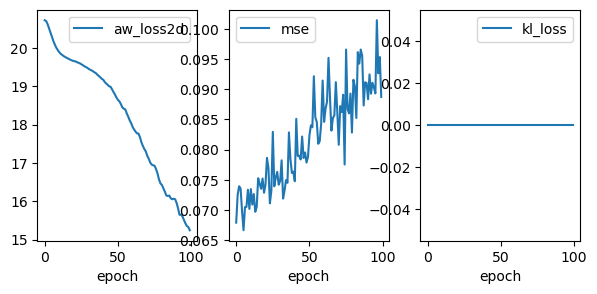

100% (100 of 100) |######################| Elapsed Time: 0:25:45 Time:  0:25:45


In [11]:
# Model and optimisers
model = CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Variational Autoencoder (CNN)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.07105135917663574, 'train_awi1d_loss': 20.72090721130371, 'train_kl_loss': 217.8638458251953}
 argidx T, v:  1512 1512


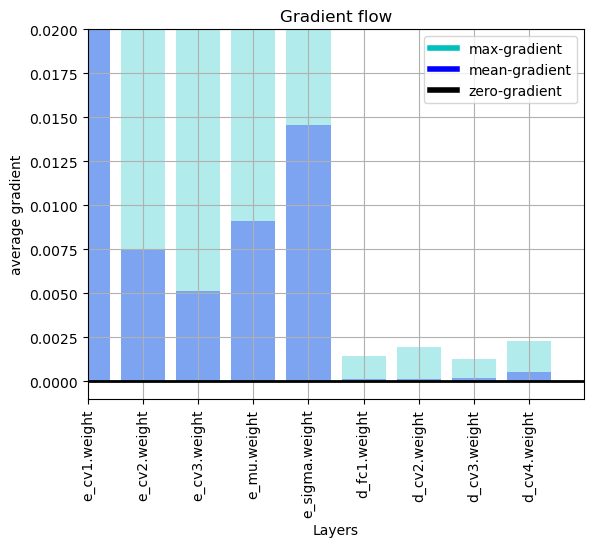

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


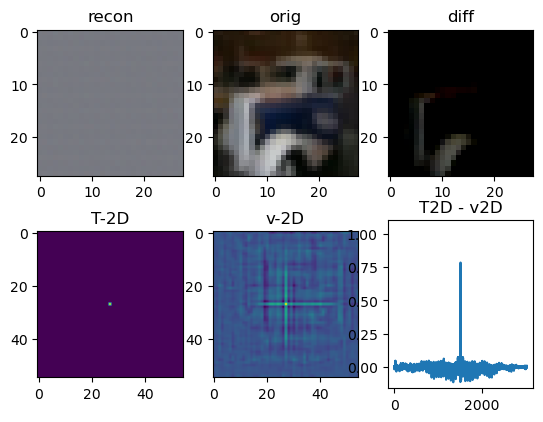

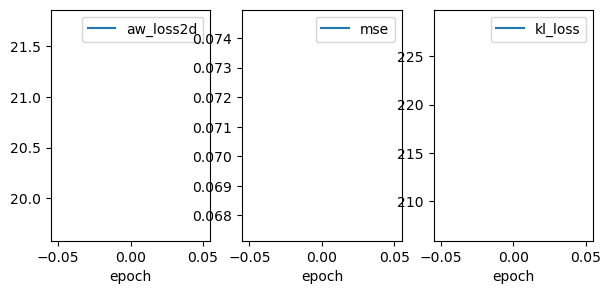

 20% (20 of 100) |####                   | Elapsed Time: 0:05:13 ETA:   0:20:39


 {'epoch': 20, 'train_mse': 0.075208380818367, 'train_awi1d_loss': 19.836681365966797, 'train_kl_loss': 216.0145721435547}
 argidx T, v:  1512 1512


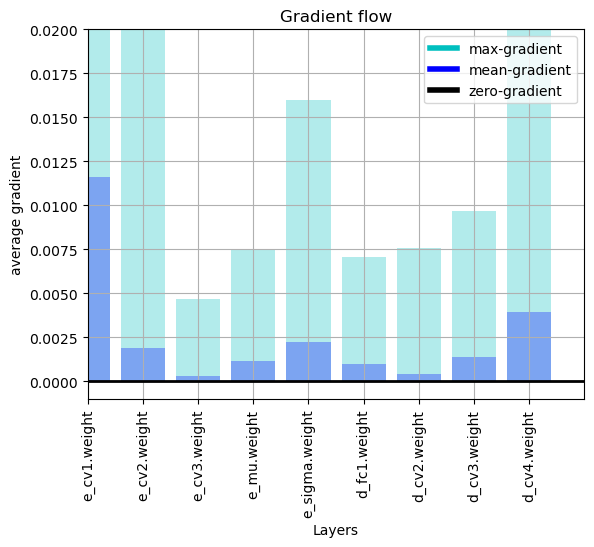

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


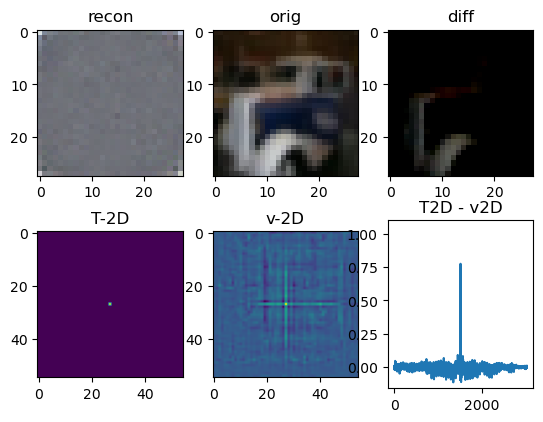

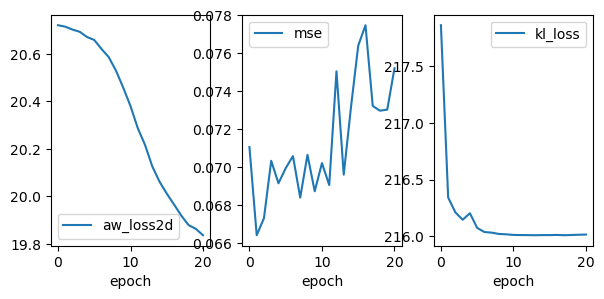

 40% (40 of 100) |#########              | Elapsed Time: 0:10:24 ETA:   0:15:29


 {'epoch': 40, 'train_mse': 0.07696622610092163, 'train_awi1d_loss': 19.710792541503906, 'train_kl_loss': 216.00160217285156}
 argidx T, v:  1512 1512


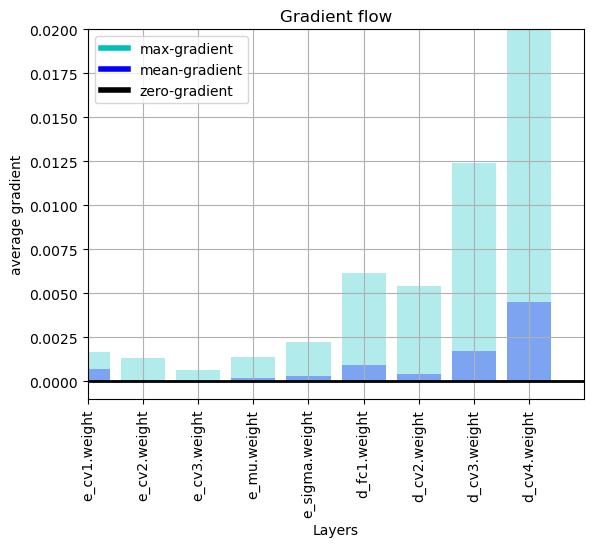

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


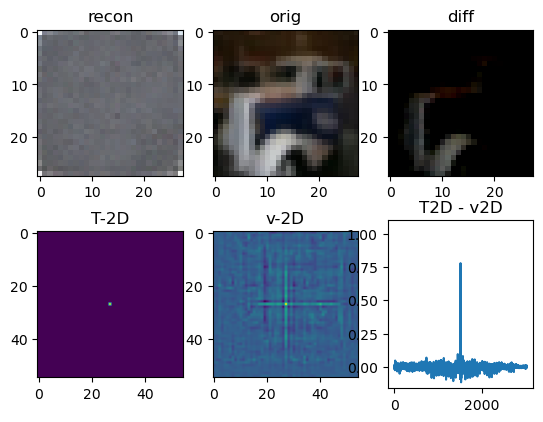

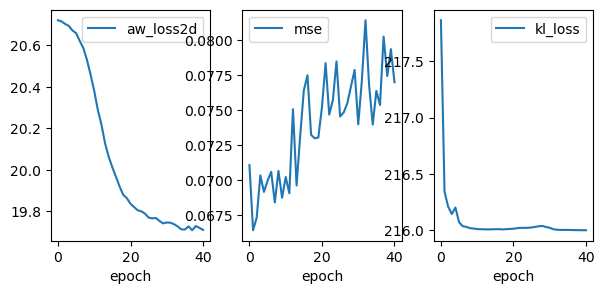

 60% (60 of 100) |#############          | Elapsed Time: 0:15:35 ETA:   0:10:24


 {'epoch': 60, 'train_mse': 0.07918272912502289, 'train_awi1d_loss': 19.687294006347656, 'train_kl_loss': 216.00076293945312}
 argidx T, v:  1512 1512


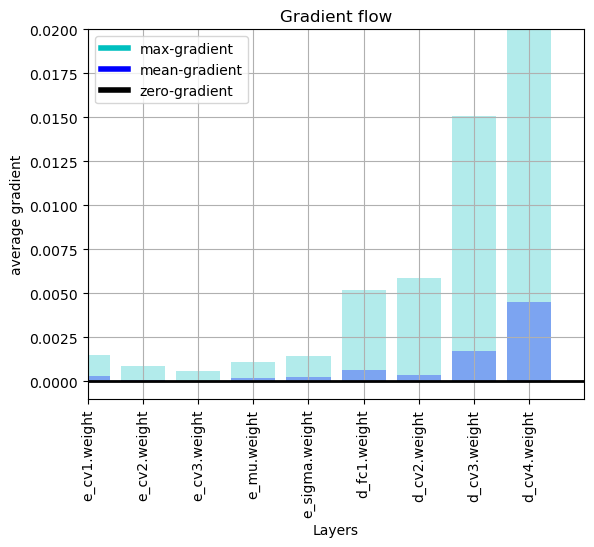

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


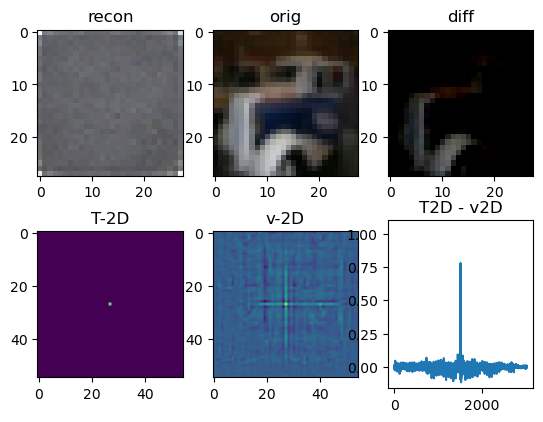

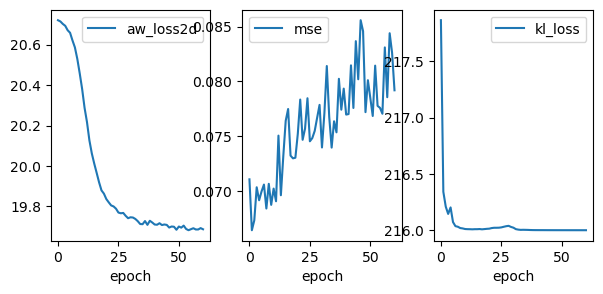

 80% (80 of 100) |##################     | Elapsed Time: 0:20:47 ETA:   0:05:09


 {'epoch': 80, 'train_mse': 0.08046561479568481, 'train_awi1d_loss': 19.673202514648438, 'train_kl_loss': 216.00070190429688}
 argidx T, v:  1512 1512


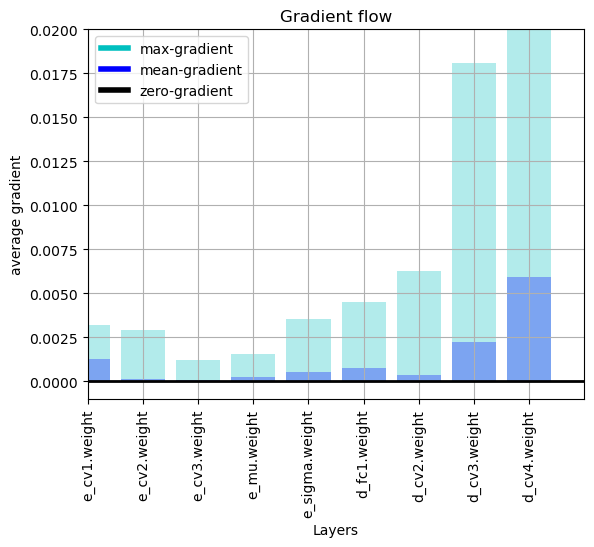

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


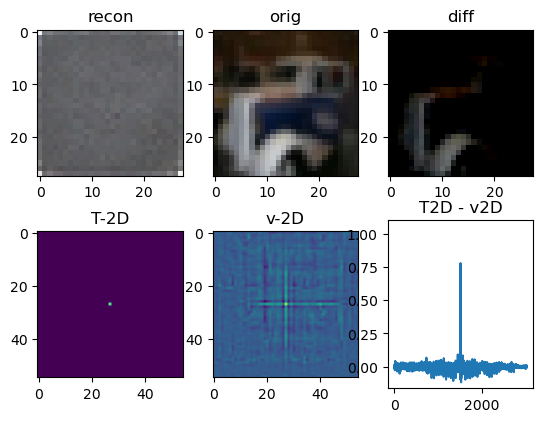

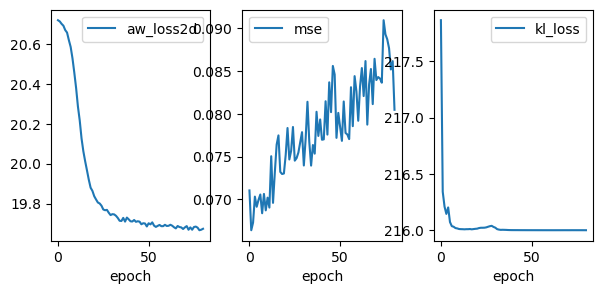

 99% (99 of 100) |###################### | Elapsed Time: 0:25:43 ETA:   0:00:15


 {'epoch': 99, 'train_mse': 0.0870574414730072, 'train_awi1d_loss': 19.670400619506836, 'train_kl_loss': 216.00282287597656}
 argidx T, v:  1512 1512


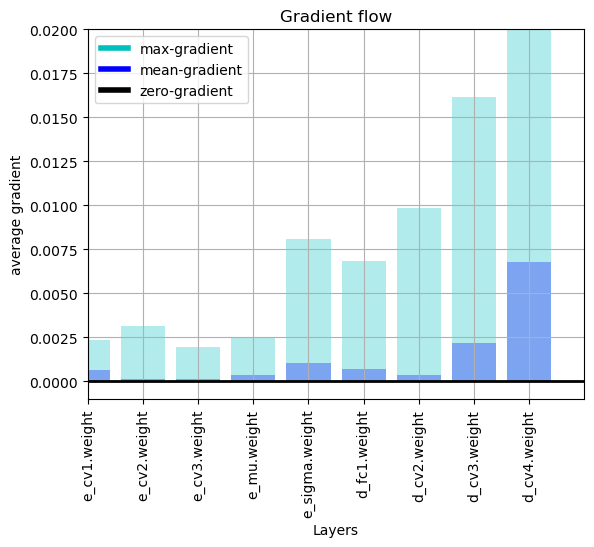

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


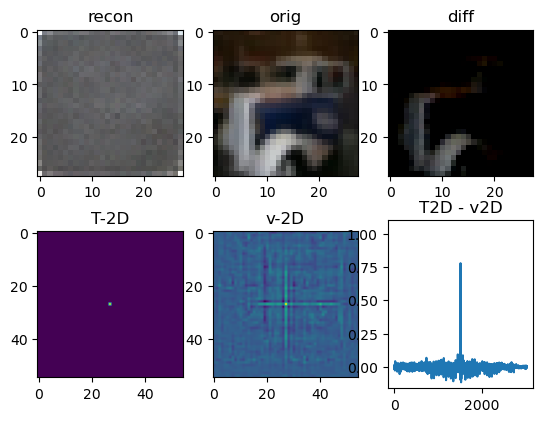

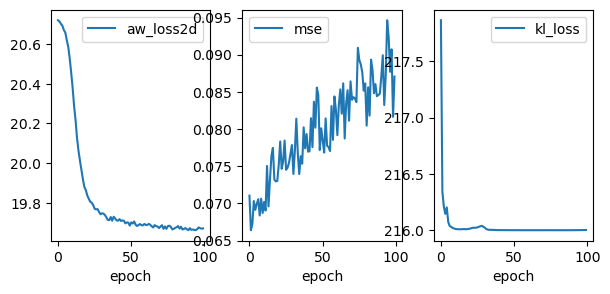

100% (100 of 100) |######################| Elapsed Time: 0:25:44 Time:  0:25:44


In [12]:
model = CVAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)